- title: Imitation Learning
- summary: step by step practical about BC
- author: Silvia TULLI
- feedback and revision: Kim BARAKA, Mohamed CHETOUANI, Muhan HOU
- teaching assistant: Márton Bodó, Fabiano Busca
- date: 2026-February-March

This notebook contains an excerpt from the **Human-Interactive Robot Learning (HIRL)** educational module.\
For more information check out [our website](https://sites.google.com/view/hirl-education?usp=sharing).


The practical can be done alone or with a colleague. Please add below your information.

Student(s):\
(1) NAME___________________ SURNAME___________________ ID___________________ Course___________________\
(2) NAME___________________ SURNAME___________________ ID___________________ Course___________________



# **Goals**
* Understand and apply Imitation Learning (IL) techniques to simple tasks.
* Implement direct Behavioral Cloning (BC) algorithm.
* Experiment with parameters such as the number of demonstrations to analyze their impact on performance.

# **Imitation learning**

Imitation Learning (IL) is a set of techniques aimed at training a model to directly mimic an expert's actions from a collection of demonstrations. In this practical, we focus on **offline imitation learning**, meaning we assume there exists a dataset consisting of demonstration data in which each sample correspond to a state-action pair collected from the expert. In practice, this might mean collecting keystrokes of a human player on an Atari game, controls of a human-driven car, or medical decisions of a doctor along a course of treatment. In this case, the goal of an IL algorithm is to learn a policy (i.e., a full mapping from states to actions) that mimics the expert policy (for which you only have a set of observations).

# **Behavioral Cloning (BC)**

Behavioral Cloning is a simple but effective imitation learning technique that involves training a model by learning a direct mapping from states to actions, without any intermediate representation.



We're tackling imitation learning within a specific environment characterized by a discrete Markov Decision Process (MDP) with a fixed time horizon of $T$. There is an expert policy, denoted as $\pi^*$, which provides deterministic actions at each state.

The input of a Behavioral Cloning algorithm is a restricted policy class $\Pi=\{\pi: S \mapsto \Delta(A)\}$

$$
\begin{array}{r}
\pi_\theta =\arg \min _{\pi \in \Pi} \sum_{i=1}^{M} \ell\left(\pi, s^{\star}, a^{\star}\right) \\
\text { loss function }
\end{array}
$$

We consider a set of human expert trajectories that adhere to $\pi$ and we aim to create an imitation policy, $\pi_\theta$, that replicates these expert trajectories effectively. The objective is to ensure that for each state, the action chosen by our policy $\pi_θ$ is exactly the same as the action chosen by the expert policy $\pi$.

In simpler terms, we aim to develop a policy that perfectly imitates the expert's actions in the given environment, making deterministic choices at each state to mimic the expert's behavior precisely.

# **Environment Set up**

First, we define the environment, in this case a 5x5 gridworld. We also define the transition probabilities for each action.

## Environment 1 definition

The environment looks like this:\
![grid](https://drive.google.com/uc?id=1cq-2fJ3pRMqDJp179xShCR3TsYBue_TV)
![action space](https://drive.google.com/uc?id=1UogrQp_KsuXPHl70RWcpe8BVfQTXlY32)
 ![actions](https://drive.google.com/uc?id=1OlXjbkEWVp-VSzc-RZ1B6OQXLOrTAFGI)\
 Each state is represented by a number.
 The goal is to reach the `State 25` (i.e., flag cell) from any random state. There are three obstacles (i.e., TNT cells). The four actions that the agent can execute are: Up - Down - Left - Right. The agent cannot cross walls; therefore, the action space looks as pictured above.




The transition matrix defines an MDP (Markov Decision Process) representing a system's dynamics and the impact of a specific action, labeled as `Action Up`. The matrix's rows correspond to distinct states within the MDP, ranging from state 1 (cell 0) to state 25 (cell 24). Each column represents a potential subsequent state that the system might transition to when `Action Up` is taken.

Example of a transition matrix for Action Up (0)
```
#               1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25                
Pu = np.array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],  # 1
               [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],  # 2
               [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],  # 3
               [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],  # 4
               [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],  # 5
               ...
])
```


In the given context:

The rows symbolize the current state of the system within the MDP, comprising $25$ distinct states.
The columns represent the feasible future states that the system can transition to when `Action Up` is executed.
The values in the matrix signify the probabilities of transitioning from the current state (row) to a specific subsequent state (column) upon taking `Action Up`.

For instance, examining the first row `State 1`, it demonstrates a probability of $1.0$ (or $100$%) of transitioning to `State 1` when `Action Up` is performed. This implies that if the system is presently in `State 1` and `Action Up` is executed, it will unquestionably move to `State 1`.

Conversely, examining the first column provides insights into the probabilities of transitioning to different states from any initial state when `Action Up` is employed. For `Action Up`, the system is more inclined to remain in the same state (diagonal elements are 1.0) and less likely to transition to other states (off-diagonal elements are 0.0).

It's important to note that this MDP describes the system's probabilistic behavior in response to `Action Up` and is distinct from a standard Markov chain, as it incorporates the notion of making decisions (in this case, taking an action) and observing the subsequent state transitions.

Below an example representation of an MDP from wikipedia:\
![wikipedia](https://upload.wikimedia.org/wikipedia/commons/thumb/a/ad/Markov_Decision_Process.svg/400px-Markov_Decision_Process.svg.png).\

Here you can observe that from $S0$ by performing $a0$ there is 50% of probability of staying in $S0$ and 50% of probability of going to $S2$.

In [1]:
!pip install torch


[notice] A new release of pip is available: 24.3.1 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


## Imports

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import matplotlib.pyplot as plt
from typing import Tuple, List, Optional
import random

### **Question 1**

* Fill in the blank spaces (i.e., the function of reset and step) with your code to specify the deterministic environment dynamics of the 5x5 gridworld defined above (not the example figure of MDP from wikipedia).



In [3]:
# GridWorldEnvironment class
class GridWorldEnvironment:
    def __init__(self, grid_size: Tuple[int, int] = (5, 5), obstacles: List[int] = []) -> None:
        self.grid_size = grid_size
        self.state_space = np.prod(grid_size)
        self.action_space = 4  # Four possible actions: Up, Down, Left, Right
        self.state: Optional[int] = None
        self.obstacles = obstacles

    def reset(self) -> Optional[int]:
        # Randomly select an initial state that is not an obstacle
        ''' Add your code here '''
        states = range(self.state_space)
        available_states = [s for s in states if s not in self.obstacles]
        if len(available_states) == 0:
            print("Impossible environment, cannot find any available states")
            self.state = None
        else:
            self.state = random.choice(available_states)
        return self.state


    def step(self, action: int) -> Tuple[int, int, bool]:
        if self.state is None:
            raise Exception("You must call reset() before step()")

        if action not in range(self.action_space):
            raise Exception("Invalid action")

        # Define transitions for each action (move in the grid)
        ''' Add your code here '''
        row = self.state // self.grid_size[0]
        col = self.state % self.grid_size[1]

        if action == 0 and row > 0:                         # Up
            row -= 1
        elif action == 1 and col < self.grid_size[1] - 1:   # Right
            col += 1
        elif action == 2 and row < self.grid_size[0] - 1:   # Down
            row += 1
        elif action == 3 and col > 0:                       # Left
            col -= 1

        next_state = row * self.grid_size[1] + col

        # Update the state if the next state is not an obstacle
        if next_state not in self.obstacles:
            self.state = next_state
        else:
            return self.state, -1, False  # Negative reward for hitting an obstacle

        # Define the reward function (e.g., reaching a goal state)
        done = (self.state == self.state_space - 1)  # Goal state
        reward = 1 if done else 0

        return self.state, reward, done

# **Dataset Generation**
Then we generate our dataset of expert demonstrations, which are represented as a state-action pairs $(s,a)$.

### **Question 2**

* Fill in the blank spaces (i.e., the function of simple_policy) with your code to specify a simple policy that avoids obstacles and follows a right-down strategy (i.e., first moving right until hit the wall, then moving down to reach the goal, or moving left if neither moving right or down is possible in the cases of obstalces).

In [4]:
# Generate expert demonstrations
def generate_expert_demonstrations(env: GridWorldEnvironment, num_demos: int) -> List[List[Tuple[int, int]]]:
    expert_demonstrations = []

    for _ in range(num_demos):
        state = env.reset()
        trajectory = []

        while state != env.state_space - 1:  # Continue until reaching the goal state
            # Define a policy to reach the goal state while avoiding obstacles
            action = simple_policy(env, state)
            next_state, reward, done = env.step(action)
            trajectory.append((state, action))
            state = next_state


        expert_demonstrations.append(trajectory)

    return expert_demonstrations

def simple_policy(env: GridWorldEnvironment, state: int) -> int:
    # A simple policy that avoids obstacles and follows a right-down strategy.
    ''' Add your code here '''
    row = state // env.grid_size[0]
    col = state % env.grid_size[1]

    def is_free(r: int, c: int) -> bool:
        if r < 0 or r >= env.grid_size[0] or c < 0 or c >= env.grid_size[1]:
            return False
        s = r * env.grid_size[1] + c
        return s not in env.obstacles

    # Right
    if is_free(row, col + 1):
        return 1  # Right

    # Down
    if is_free(row + 1, col):
        return 2  # Down

    # Fallbacks
    if is_free(row, col - 1):
        return 3  # Left
    if is_free(row - 1, col):
        return 0  # Up

    return 0

# Create the grid world environment
env = GridWorldEnvironment(obstacles=[7, 8, 12])

# Generate expert demonstrations
num_demos = 10  # You can adjust the number of demonstrations
expert_demonstrations = generate_expert_demonstrations(env, num_demos)

# Print the expert demonstrations
for idx, demo in enumerate(expert_demonstrations):
    print(f"Expert Demonstration {idx + 1}: {demo}")

Expert Demonstration 1: [(16, 1), (17, 1), (18, 1), (19, 2)]
Expert Demonstration 2: [(21, 1), (22, 1), (23, 1)]
Expert Demonstration 3: [(10, 1), (11, 2), (16, 1), (17, 1), (18, 1), (19, 2)]
Expert Demonstration 4: [(17, 1), (18, 1), (19, 2)]
Expert Demonstration 5: [(17, 1), (18, 1), (19, 2)]
Expert Demonstration 6: [(17, 1), (18, 1), (19, 2)]
Expert Demonstration 7: [(6, 2), (11, 2), (16, 1), (17, 1), (18, 1), (19, 2)]
Expert Demonstration 8: [(14, 2), (19, 2)]
Expert Demonstration 9: [(1, 1), (2, 1), (3, 1), (4, 2), (9, 2), (14, 2), (19, 2)]
Expert Demonstration 10: [(17, 1), (18, 1), (19, 2)]


In this example the expert agent attempts to move right when it's possible (i.e., not in the last column), and when it reaches the last column, it moves down. This policy is designed to guide the agent toward the goal state located in the bottom-right corner of the grid.

Below we can observe that the demonstrations dataset comprises of state-action pairs.

In [5]:
expert_demonstrations

[[(16, 1), (17, 1), (18, 1), (19, 2)],
 [(21, 1), (22, 1), (23, 1)],
 [(10, 1), (11, 2), (16, 1), (17, 1), (18, 1), (19, 2)],
 [(17, 1), (18, 1), (19, 2)],
 [(17, 1), (18, 1), (19, 2)],
 [(17, 1), (18, 1), (19, 2)],
 [(6, 2), (11, 2), (16, 1), (17, 1), (18, 1), (19, 2)],
 [(14, 2), (19, 2)],
 [(1, 1), (2, 1), (3, 1), (4, 2), (9, 2), (14, 2), (19, 2)],
 [(17, 1), (18, 1), (19, 2)]]

### **Question 3**

In the code above, we collected demonstrations that were generated by a rule-based simple policy as they were given from a human.

* Can you come up with any other alternative demonstrations for this environment (e.g., based on an alternative policy)?
* Can you suggest any other ways to generate these demonstrations (as opposed to being generated by a predefined policy)?

### **Your answers to Question 3**

* Q3.1:

* Q3.2:


# **Define the Behavioral Cloning Model**

We set up the Python environment and import necessary libraries, including TensorFlow or PyTorch, depending on your preference.

# Model Structure
The BehavioralCloningModel described below consists of a Neural Network with three fully connected (dense) layers:\
Input (1D) -> [fc1] -> [ReLU] -> [fc2] -> [ReLU] -> [fc3] -> Output (Mapping from states to deterministic actions)
* `Input (1D)` represents the input layer with a single node, as state_dim is 1.
* `[fc1]` represents the first fully connected layer with 64 neurons.
* `[ReLU]` represents the Rectified Linear Unit (ReLU) activation function applied after each fully connected layer.
* `[fc2]` represents the second fully connected layer with 64 neurons.
* `[fc3]` represents the third fully connected layer, which outputs the mapping from states to deterministic actions. The number of neurons in this layer is determined by action_dim.

The arrows between layers represent the connections and transformations of data as it flows through the network during forward pass. The ReLU activation functions introduce non-linearity in the model.

The model learns a policy using **supervised learning** by minimizing the loss function. In behavioral cloning, the model is trained to predict actions that are as close as possible to the actions taken by the expert. Accuracy is then used to evaluate the model.

In the code below, the **cross-entropy loss** quantifies the dissimilarity between the model's predicted action and the true actions from the expert.

In the context of behavioral cloning for deterministic environments (where expert actions are treated as deterministic), the cross-entropy loss is used to train the model to predict actions that resemble the expert's actions. However, it's important to note that this approach assumes that the expert's actions are ground truth.


Find out more about cross-entropy loss in [3.2.1.3 Log Loss Function](https://takaosa.github.io/paper/algorithmic-perspective-imitation.pdf).
A general overview of imitation learning approaches, including different loss functions can be found in [Imitation Learning Lecture](https://web.stanford.edu/class/cs237b/pdfs/lecture/lecture_10111213.pdf) from Stanford.

![architecture](https://drive.google.com/uc?id=14NuVh8bLTX9Og1peV3y7_1yygCTO0i4I)


### **Question 4**
* Fill in the blank spaces (i.e., in the function of train) with your code to calculate accuracy for the current epoch and store it. You will use your saved results for plotting in the next question.

In [16]:
# Define the Behavioral Cloning Model
class BehavioralCloningModel(nn.Module):
    def __init__(self, state_dim: int, action_dim: int) -> None:
        super(BehavioralCloningModel, self).__init__()
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def train(self, states: List[List[int]], actions: List[int], epochs: int = 50, batch_size: int = 32) -> Tuple[List[float], List[float], float, float]:
        optimizer = optim.Adam(self.parameters(), lr=0.001)
        loss_fn = nn.CrossEntropyLoss()

        states = torch.tensor(states, dtype=torch.float32)
        print('states', states)
        actions = torch.tensor(actions, dtype=torch.int64)

        dataset = torch.utils.data.TensorDataset(states, actions)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

        accuracy_values = []
        loss_values = []  # Initialize loss_values to track loss values

        for epoch in range(epochs):
            total_loss = 0.0
            correct_predictions = 0

            for batch_states, batch_actions in dataloader:
                optimizer.zero_grad()
                predicted_actions = model(batch_states)
                loss = loss_fn(predicted_actions, batch_actions)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()

                # Calculate the number of correct predictions in the current batch
                correct_predictions += (predicted_actions.argmax(dim=1) == batch_actions).sum().item()

            # Calculate accuracy for the current epoch and store it
            ''' Add your code here '''
            accuracy = correct_predictions / len(dataset)
            accuracy_values.append(accuracy)

            # Append the average loss for the current epoch to loss_values
            loss_values.append(total_loss / len(dataloader))

            print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss_values[-1]:.4f}, Accuracy: {accuracy * 100:.2f}%')

        # Calculate standard deviation for loss and accuracy
        loss_std = np.std(loss_values)
        accuracy_std = np.std(accuracy_values)

        return loss_values, accuracy_values, loss_std, accuracy_std # Return loss and accuracy values

# Extract states and actions from expert demonstrations
states = []
actions = []

for demonstration in expert_demonstrations:
    for state, action in demonstration:
        states.append([state])  # Wrap the state in a list to make it 2D (1x1)
        actions.append(action)

# Define state_dim and action_dim based on your data
state_dim = 1  # Assuming state is a scalar value
action_dim = max(actions) + 1  # Calculate action_dim based on the maximum action value

# Instantiate the model
model = BehavioralCloningModel(state_dim, action_dim)

# Train the model with the expert demonstration data
loss_values, accuracy_values, loss_std, accuracy_std = model.train(states, actions, epochs=500, batch_size=32)

states tensor([[16.],
        [17.],
        [18.],
        [19.],
        [21.],
        [22.],
        [23.],
        [10.],
        [11.],
        [16.],
        [17.],
        [18.],
        [19.],
        [17.],
        [18.],
        [19.],
        [17.],
        [18.],
        [19.],
        [17.],
        [18.],
        [19.],
        [ 6.],
        [11.],
        [16.],
        [17.],
        [18.],
        [19.],
        [14.],
        [19.],
        [ 1.],
        [ 2.],
        [ 3.],
        [ 4.],
        [ 9.],
        [14.],
        [19.],
        [17.],
        [18.],
        [19.]])
Epoch 1/500, Loss: 1.7357, Accuracy: 10.00%
Epoch 2/500, Loss: 1.2633, Accuracy: 55.00%
Epoch 3/500, Loss: 1.0080, Accuracy: 57.50%
Epoch 4/500, Loss: 0.8626, Accuracy: 57.50%
Epoch 5/500, Loss: 0.7985, Accuracy: 55.00%
Epoch 6/500, Loss: 0.8347, Accuracy: 40.00%
Epoch 7/500, Loss: 0.7942, Accuracy: 42.50%
Epoch 8/500, Loss: 0.7058, Accuracy: 55.00%
Epoch 9/500, Loss: 0.7269, Accuracy: 60.

### **Question 5**
* Fill in the blank spaces with your code to plot the training results of loss and accuracy respectively (i.e., two figures in total). For each figure, use the epoch number as the x-axis and the corresponding measurement (either loss or accuracy) as the y-axis.

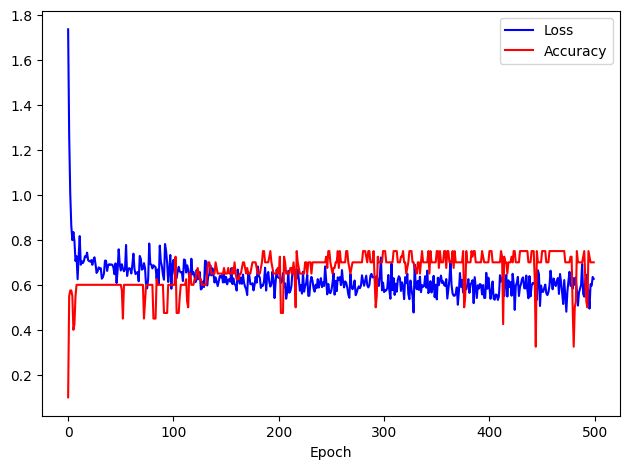

In [17]:
epochs = 500
# Define lighter colors for the standard deviation lines
lighter_blue = "b"
lighter_red = "r"

# Plot Loss and Accuracy
''' Add you code here'''
plt.plot(loss_values, color=lighter_blue, label="Loss")
plt.plot(accuracy_values, color=lighter_red, label="Accuracy")


plt.xlabel("Epoch")
plt.legend()

plt.tight_layout()
plt.show()

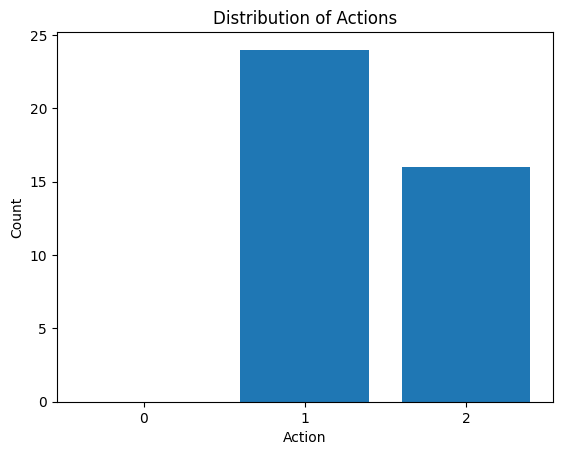

In [8]:
# Visualize the Distribution of Actions
action_counts = [actions.count(i) for i in range(action_dim)]
plt.bar(range(action_dim), action_counts)
plt.xticks(range(action_dim))
plt.xlabel("Action")
plt.ylabel("Count")
plt.title("Distribution of Actions")
plt.show()

Note that while the term *probabilities* might imply a probabilistic policy, in this deterministic case, these values represent the model's confidence or preference for each possible action given a particular state.

# **Submission of your assignment**

* submit your completed colab file

* save and submit your two figures plotted in Question 5

# **References**
* D. A. Pomerleau. Efficient training of artificial neural networks for autonomous navigation. Neural Computation, 3:88–97, 1991.
* F. Torabi, G. Warnell, and P. Stone. Behavioral cloning from observation. ArXiv, abs/1805.01954, 2018.
* [Imitation Learning open source library](https://imitation.readthedocs.io/en/latest/algorithms/bc.html)
* CS 285 at UC Berkeley, [Deep Reinforcement Learning](https://rail.eecs.berkeley.edu/deeprlcourse/)
* M. Chetouani. Interactive Robot Learning: An Overview. Chetouani, M.; Dignum, V.; Lukow- icz, P.; Sierra, C. Human-Centered Artificial Intelligence, 13500, Springer International Publishing, pp.140-172, 2023, Lecture Notes in Computer Science, 10.1007/978-3-031-24349-3_9 . [hal-04060804](https://hal.science/hal-04060804/file/ACAI2021_chetouani_author-version.pdf)
